In [70]:
import math
import statistics
import random
import numpy as np
import matplotlib
import time

import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count
from PIL import Image
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from itertools import count

from tensorboardX import SummaryWriter

#from env import MancalaEnv
from game import Game
from randomagent import AgentRandom
from exactagent import AgentExact

In [71]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [72]:
class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, state_size, n_actions):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(state_size, 512)
        self.hidden1 = nn.Linear(512, 128)

        # actor's layer
        self.action_head = nn.Linear(128, n_actions)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x = self.hidden1(x)
        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values

## Create Policy and Model

In [73]:
model = Policy(14, 6)
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

GAMMA = 0.999
SEED = 123


In [74]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()

In [75]:
def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + GAMMA * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


In [76]:
def sparse_reward(game, idx):
    done = game.over()
    next_state = np.array(game.board())
    dqn_score, agent_score = game.score()
    win = False
    if((dqn_score > agent_score) and done):
        reward = 1
        win = True 
    else:
        reward = -1
    return(next_state, reward, done, win)

def keep_ahead_reward(game, idx):
    done = game.over()
    next_state = np.array(game.board())
    dqn_score, agent_score = game.score()
    win = False

    if((dqn_score - agent_score) > 0):
        reward = 1
    else:
        reward = 0
    
    if((dqn_score > agent_score) and done):
        win = True
        reward = 10

    return(next_state, reward, done, win)

def dont_fall_behind_reward(game, idx):
    done = game.over()
    next_state = np.array(game.board())
    dqn_score, agent_score = game.score()
    win = False
    if((dqn_score - agent_score) < 0):
        reward = -1
    else:
        reward = 0

    if((dqn_score > agent_score) and done):
        win = True 
        reward = 10

    return(next_state, reward, done, win)

In [77]:
def actor_critic(num_episodes = 1000):
    running_reward = 10
    n_episodes = num_episodes
    opponent = AgentRandom()
    winsarray = np.zeros(shape = (1,2)) # Story which episode saw wins
    # run inifinitely many episodes
    for i_episode in tqdm(range(1, n_episodes+1)):

        # reset environment and episode reward
        game = Game()
        #state = env.reset()
        ep_reward = 0
        done = False
        win =False
        state = np.array(game.board())
        # for each episode, only run 9999 steps so that we don't 
        # infinite loop while learning
        while not done:
            action = select_action(state) # Select an action
            next_state, reward, done, win = sparse_reward(game, i_episode) # Get next state, reward and if game is done as result of action

            ''' TAKING AN ACTION '''
            game.move(action) # Take the action on the Game board

            
            game._player_one = False
            game.move(opponent._move(game))
            game._player_one = True
            next_state, reward, done, win = sparse_reward(game, i_episode) # Get next state, reward and if game is done as result of action

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                if win:
                    winsarray = np.append(winsarray, [[i_episode,1]], axis = 0)
                else:
                    winsarray = np.append(winsarray, [[i_episode,0]], axis = 0)
                break

        

        # perform backprop
        finish_episode()
    return(winsarray)
        

        


In [78]:
scores = actor_critic(100)

  4%|▍         | 4/100 [00:00<00:18,  5.27it/s]1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
  9%|▉         | 9/100 [00:00<00:10,  8.36it/s]
1.1920928955078125e-07
1.1920928955078125e-07
 11%|█         | 11/100 [00:00<00:09,  9.82it/s]
1.1920928955078125e-07
1.1920928955078125e-07
 13%|█▎        | 13/100 [00:01<00:09,  8.80it/s]1.1920928955078125e-07
1.1920928955078125e-07
 15%|█▌        | 15/100 [00:01<00:09,  8.90it/s]1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
 19%|█▉        | 19/100 [00:01<00:08,  9.95it/s]1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
 23%|██▎       | 23/100 [00:01<00:06, 11.80it/s]1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
 25%|██▌       | 25/100 [00:02<00:06, 12.45it/s]
1.1920928955078125e-07
1.1920928955078125e-07
 29%|██▉       | 29/100 [00:02<00:04, 14.47it/s]1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078

KeyboardInterrupt: 

<function matplotlib.pyplot.show(*args, **kw)>

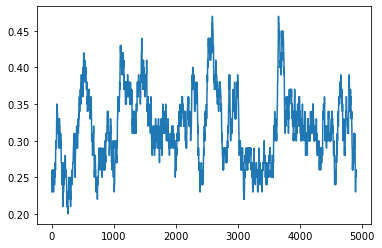

In [69]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

avg = moving_average(scores[:,1], 100)

plt.plot(avg)
plt.show